In [23]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from GB84 import variables, rho_m, v,cloud_heights, h_out, phi, f, non_dim_numbers
from kalman_filter import kalman_filter as kf

### Testing the model

In [24]:
measurements = xr.open_mfdataset(r'data\davis-TUD-GV_Green_Village_202407.nc')

In [25]:
var = ['temperature','pressure','humidity','rain_rate']
measurements = measurements[var]
measurements = measurements.dropna(dim='time',how='any')

In [26]:
#Kalman filter measurements

kf_measurements = measurements['rain_rate'].values[7000:10000:30]

In [27]:
#inputs

#temperature on the ground
T_surf_C = measurements['temperature'].values[7000:10000] #[C]
T_surf = T_surf_C + 273.15    # [K]

#pressure
p_surf = measurements['pressure'].values[7000:10000]*100    #[Pa]

#dew point temperature
RH = measurements['humidity'].values[7000:10000]
alpha_T = 17.27*T_surf_C/(T_surf_C + 237.7) + np.log(RH/100) #from http://dx.doi.org/10.31648/ts.5425
T_d_arr = 237.7*alpha_T/(17.27 - alpha_T) + 273.15      #[K]

#state
X = np.zeros(len(T_surf))
X[0] = 20   #initial state in kg/m2
Sigma = np.zeros(len(T_surf))
Sigma[0] = 5 #initial state covariance in kg/m2

#timestep
dt= 60      #timestep in s

In [28]:
#loop for finding the precipitation given the T_0 and p
P = np.zeros(len(T_surf))
P_0 = np.zeros(len(T_surf))
for i in range(0,len(T_surf)):
    #inputs
    T_0 = T_surf[i]
    p_0 = p_surf[i]
    T_d = T_d_arr[i]

    #meteorological variables
    p_s,T_s,p_t, T_m, T_t,T_s_up, p_s_up = variables(T_0, T_d, p_0, obs=False).run()
    rho = rho_m(T_s,T_t,p_s,p_t)
    v_updr = v(T_m,T_s_up)
    Z_c,Z_b = cloud_heights(T_s,T_t,T_0,p_s,p_t,p_0)
    O_b,O_t,h_v = h_out(v_updr,Z_c).run()   #outflows and sources of water
    
    #precipitation in kg/m2/s
    P_0[i] = phi(T_0, p_0, T_d, Z_b, Z_c,v_updr).calculate_phi()*X[0]
    P[i] = phi(T_0, p_0, T_d, Z_b, Z_c,v_updr).calculate_phi()*X[i] #*X[i] if we are using the updated state
    print(f(T_d,p_0,p_t,T_t,rho,v_updr) \
                                  - h_out(v_updr,Z_c).run()[2])
    
    #state with Kalman filter   
    if i>0:
        if (i%30)==0:
            # we assume that we receive a precipitation update every 30mins
            j = int(i/30)
            if kf_measurements[j]>0:
                phi_kf = phi(T_0, p_0, T_d, Z_b, Z_c,v_updr).calculate_phi()
                h_kf = h_out(v_updr,Z_c).run()[2]
                f_kf = f(T_d,p_0,p_t,T_t,rho,v_updr)
            
                kalman_f = kf(X[i], Sigma[i], dt,h_kf,phi_kf,f_kf,kf_measurements[j]) 
                X[i],Sigma[i] = kalman_f.update()
    
    if i<(len(T_surf)-1):
        X[i+1] = X[i]
        Sigma[i+1] = Sigma[i]

[0.0006639]
[0.0006639]
[0.0006639]
[0.00066384]
[0.00066379]
[0.00066379]
[0.00066379]
[0.00066384]
[0.00066379]
[0.00066379]
[0.00066579]
[0.0006659]
[0.00066584]
[0.00066584]
[0.0006659]
[0.0006659]
[0.0006659]
[0.00066574]
[0.00066825]
[0.00066825]
[0.00066825]
[0.00066825]
[0.00066825]
[0.00066825]
[0.0006703]
[0.0006703]
[0.00067019]
[0.00067019]
[0.00067019]
[0.00067003]
[0.00067003]
[0.00067003]
[0.00067003]
[0.00066998]
[0.00067243]
[0.00067243]
[0.00067243]
[0.00067232]
[0.00065851]
[0.00065846]
[0.00066089]
[0.00066094]
[0.00066089]
[0.00066089]
[0.00066084]
[0.00066078]
[0.00066073]
[0.00066078]
[0.00066084]
[0.00066078]
[0.00066067]
[0.00066073]
[0.00066062]
[0.00066062]
[0.00066073]
[0.00066265]
[0.00066062]
[0.00066062]
[0.00066062]
[0.00066057]
[0.00064679]
[0.00064674]
[0.00064663]
[0.00064658]
[0.00064663]
[0.00064653]
[0.00064647]
[0.00064406]
[0.00064406]
[0.00064401]
[0.00064159]
[0.00064149]
[0.00064143]
[0.00064149]
[0.00064149]
[0.00063937]
[0.00063937]
[0.00063

### Plots and results

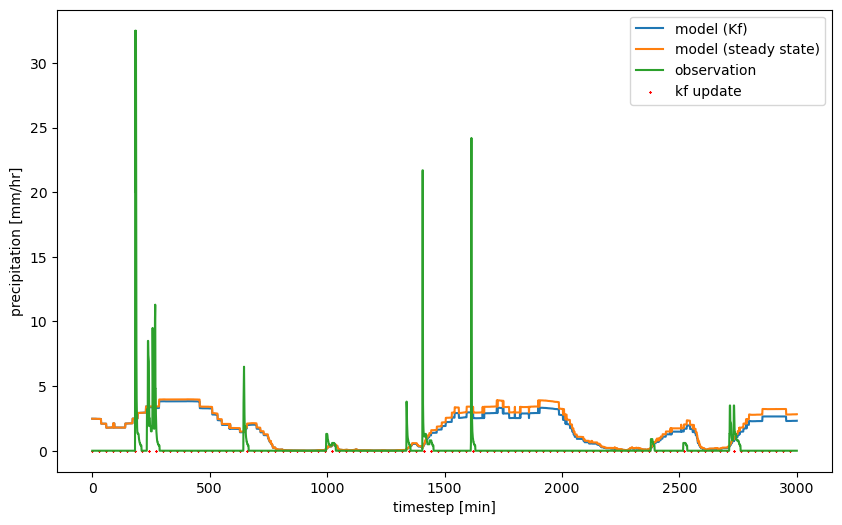

In [29]:
plt.figure(figsize=(10,6))
t_step = np.linspace(0,len(P),len(P))

plt.plot(t_step,P*3600,label='model (Kf)')   #P [kg/m2/s] = P/1000kg/m3 = P/1000 m/s = P* 3600 [mm/hr]
plt.plot(t_step,P_0*3600,label='model (steady state)')
plt.plot(t_step,measurements['rain_rate'].values[7000:10000],label='observation')
plt.scatter(t_step[0::30],np.zeros((len(kf_measurements))),label='kf update',marker='x',s=0.6,color='red')
plt.xlabel('timestep [min]')
plt.ylabel('precipitation [mm/hr]')
plt.legend()
plt.show()


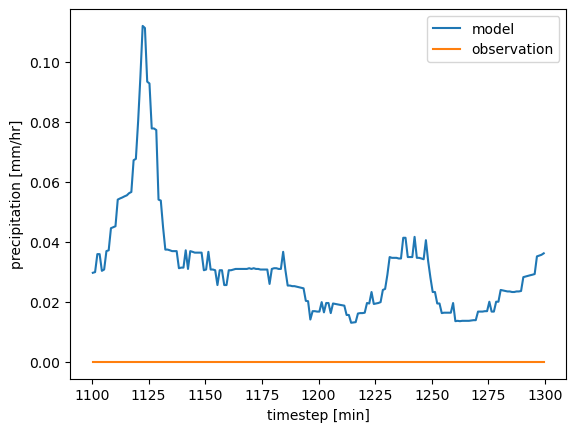

In [30]:
#zooming when no rain is observed

t_step = np.linspace(0,len(P),len(P))
plt.plot(t_step[1100:1300],P[1100:1300]*3600,label='model')
plt.plot(t_step[1100:1300],measurements['rain_rate'].values[8100:8300],label='observation')
plt.legend()
plt.xlabel('timestep [min]')
plt.ylabel('precipitation [mm/hr]')
plt.show()


Text(0, 0.5, 'liquid water [kg/m^2]')

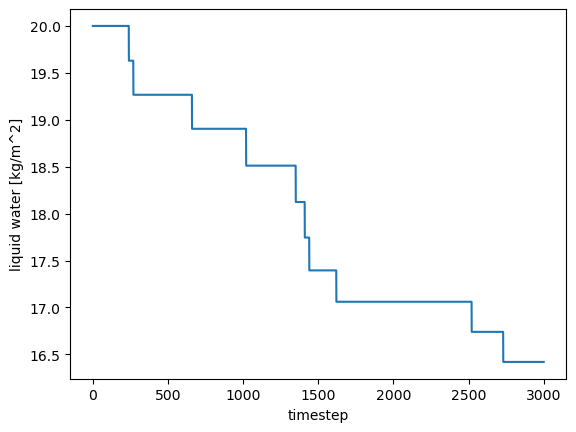

In [31]:
#state evolution

plt.plot(t_step,X)
plt.xlabel('timestep')
plt.ylabel('liquid water [kg/m^2]')

In [32]:
v_arr = np.zeros(len(T_surf))
O_b_arr = np.zeros(len(T_surf))
O_h_arr = np.zeros(len(T_surf))
I_arr = np.zeros(len(T_surf))

for i in range(0,len(T_surf)):
    #inputs
    T_0 = T_surf[i]
    p_0 = p_surf[i]
    T_d = T_d_arr[i]

    #meteorological variables
    p_s,T_s,p_t, T_m, T_t,T_s_up, p_s_up = variables(T_0, T_d, p_0, obs=False).run()
    rho = rho_m(T_s,T_t,p_s,p_t)
    v_updr = v(T_m,T_s_up)
    v_arr[i] = v_updr
    Z_c,Z_b = cloud_heights(T_s,T_t,T_0,p_s,p_t,p_0)
    O_b,O_t,h_v = h_out(v_updr,Z_c).run()   #outflows and sources of water
    O_b_arr[i] = O_b*X[i]*non_dim_numbers(v_updr)[0]/Z_c
    O_h_arr[i] = O_t*X[i]*non_dim_numbers(v_updr)[0]/Z_c
    I_arr[i] = f(T_d,p_0,p_t,T_t,rho,v_updr)
     


Text(0, 0.5, 'updraft velocity [m/s]')

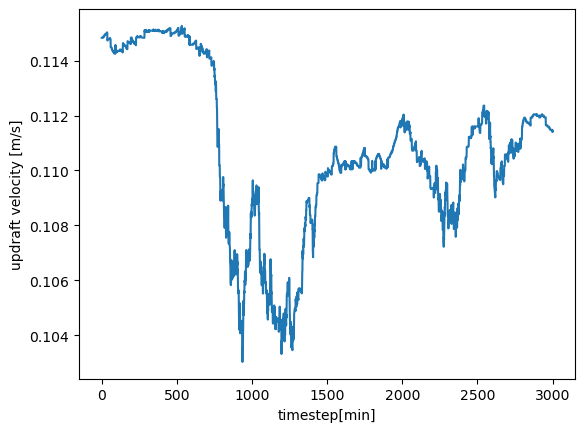

In [33]:
plt.plot(t_step,v_arr)
plt.xlabel('timestep[min]')
plt.ylabel('updraft velocity [m/s]')

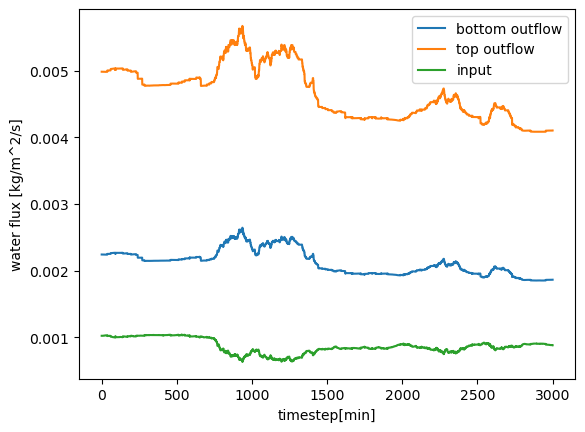

In [34]:
plt.plot(t_step,O_b_arr,label='bottom outflow')
plt.plot(t_step,O_h_arr,label='top outflow')
plt.plot(t_step,I_arr,label='input')
plt.xlabel('timestep[min]')
plt.ylabel('water flux [kg/m^2/s]')
plt.legend()

In [35]:
X[i]*non_dim_numbers(v_updr)[0]/Z_c

array([0.00218139])